In [1]:
#If the cv2 module is not found, run that:
#!pip install opencv-python

## important if  running on Colab 
switch under runtime the "Change runtime type" to a GPU support. This will speed up you calculations immensely

In [2]:
import sys,os
import numpy as np                     #main package for scientific computing with Python.
import pandas as pd                    #main data handling package
from matplotlib import image           #plot graphs in Python.
import matplotlib.pyplot as plt        #lazy plotting
import cv2                             #image opening

# Building and training a neural network

In this notebook, we are going to see and build the basic components of neural networks. We will first build from scratch a two layer neural network that we will then train to separate images from birds and images from dogs. The we will use Torch with a similar network and finally use Keras to build a sequential neural network with some advanced corrections

There are six components to artificial neurons. From left (input) to right (output). If we only consider numerical values these are:

1. Input nodes. Each input node is a real number
2. Connections with weight. Each connection that departs from the input node has a weight, which is also a real number.
3. Calculate a weighted sum: $y = \sum_{i=1}^{D} w_i*x_i$
4. Feed this sum into a transfer or activation function. 
this can be idendity, but normally this is a treshold function. e.g. $\left\{\begin{matrix}
=0 \;\text{if}\; x\leq 0.5\\ 
=1 \;\text{if}\; x>0.5
\end{matrix}\right.$<br>
Which however is not smooth, so alternatively a continous (sigmoid) function such as the logistic function is an alternative (see below)
5. output node of this chain
6. A perceptron is sometimes added to this, often this is called a bias, Which is an input node with a fixed value

With the percepton the treshold is easier defined, meaning that the transfer function can be switching at zero. (sometimes called ReLU Rectifying Linear Unit) There are other variants, but we will talk about them in the Keras section.

Text(0.5, 1.0, 'One logistic function')

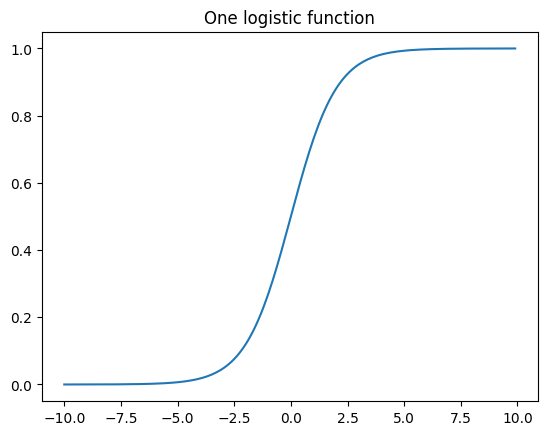

In [3]:
x=np.arange(-10,10,0.1);y=np.exp(x)/(1 + np.exp(x))
fig,ax=plt.subplots();plt.plot(x,y);ax.set_title('One logistic function')

# Data Loading
Now, we load the data that we will need for the NN

In [4]:
import sys
if "google.colab" in sys.modules:
    path_to_files = os.sep.join([os.getcwd(), "Bern02", "Labs", "Neural_Networks", "train"])
    !git clone https://github.com/luchem/Bern02.git --depth=1
else:
    path_to_files = os.sep.join([os.getcwd(), "train"])

In [5]:
#We create two empty lists to store the data (the images) and the labels (0 if bird, 1 if dog)
data=[]
labels=[]
image_size=32
#We now load the data into the notebook from the folder on your computer
for filename in os.listdir(os.sep.join([path_to_files,'bird'])):
    labels.append(0)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'bird',filename])),dsize=(image_size,image_size)))
for filename in os.listdir(os.sep.join([path_to_files,'dog'])):
    labels.append(1)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'dog',filename])),dsize=(image_size,image_size)))
data=np.array(data)
labels=np.array(labels)

FileNotFoundError: [Errno 2] No such file or directory: '/home/melanie/Documents/schoolstuff/Reprod_datascience/Labs/Lab9_NN/train/bird'

Questions:
How many data files do we have in total?<br>

Lets split this data into a training and testing dataset. While there are specific selectors for this we simply use a permutation of the index.

In [ ]:
np.random.seed(0)
idx=np.random.permutation(len(labels))
idx_train=idx[0:2000]
idx_test=idx[2001:2401]
train_x=data[idx_train]
test_x=data[idx_test]
train_y=labels[idx_train].reshape(1,-1)
test_y=labels[idx_test].reshape(1,-1)

What is the size of the images?
Does the size matter?

# Data Inspection

In [ ]:
print('the shape of the image is:')
print(train_x[0].shape)
plt.imshow(train_x[4])

# Data shaping

To avoid some divergence, we normalize the intensity of each pixels and flatten it. The flattening is a simplification to not have to deal with the dimensions. As we will be connecting every pixel the actual positions do not matter. This will be different for convolutional networks.

In [ ]:
# we use a single dimension layer, so flattening the matrix
train_x_flatten=train_x.reshape(train_x.shape[0],-1).T
test_x_flatten=test_x.reshape(test_x.shape[0],-1).T
# all values must be "normalized" meaning between 0 and 1
train_x_flatten=train_x_flatten/255
test_x_flatten=test_x_flatten/255

We will build a neural network with 2 layers
First we start by building the neural net. For this we we initialize the weights and biases for each layer.

# Neuronal net building

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    n_x -- size of input layer; 
    n_h -- size of hidden layer; 
    n_y -- size of output layer
    Returns:
    parameters -- python dictionary containing your parameters:             
    """
    W1 = np.random.randn(n_h, n_x) * 0.01 #W1 -- weight matrix of shape (n_h, n_x)
    b1 = np.zeros((n_h, 1))               #b1 -- bias vector of shape (n_h, 1)
    W2 = np.random.randn(n_y, n_h) * 0.01 #W2 -- weight matrix of shape (n_y, n_h)
    b2 = np.zeros((n_y, 1))               #b2 -- bias vector of shape (n_y, 1)    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

We now code the forward propagation through  (from the input to the output (left to right)

In [ ]:
def linear_forward(Input_Matrix, Weights, bias):
    """
    function to calculate the combination of Input, weights and bias
    forward propagation.
    Returns: Output_Matrix, (Input_Matrix, Weights, bias)
    """
    Output_Matrix = np.dot(Weights, Input_Matrix) + bias
    cache = (Input_Matrix, Weights, bias)
    return Output_Matrix, cache
def relu(Z):# forward activation (rectification function)
    return np.maximum(np.zeros(Z.shape),Z),Z
def sigmoid(Z): # forward activation (smooth rectification)
    return 1/(1+np.exp(-Z)),Z
def linear_activation_forward(Input_Matrix, Weights, bias, activation_method):
    """
    Input_Matrix: size of previous layer
    Weights: numpy array of shape (size of current layer, size of previous layer)
    bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer "sigmoid" or "relu"
    Returns: Output_Matrix, (linear_cache, activation_cache)
    """
    if activation_method == "sigmoid":
        Z, linear_cache = linear_forward(Input_Matrix, Weights, bias)
        Output_Matrix, activation_cache = sigmoid(Z)    
    elif activation_method == "relu":
        Z, linear_cache = linear_forward(Input_Matrix, Weights, bias)
        Output_Matrix, activation_cache = relu(Z)    
    cache = (linear_cache, activation_cache)
    return Output_Matrix, cache

In [ ]:
def compute_cost(Calculated_classiciation,True_classification):
    """Calculate the cost=error of the current prediction"""
    m = True_classification.shape[1] #get size of vector
    a=np.multiply(np.log(Calculated_classiciation),True_classification)
    b=np.multiply(np.log(1-Calculated_classiciation),1-True_classification)
    cost =  (-1./m)*np.sum(a+b)
    cost = np.squeeze(cost)# To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

1. In the forward propagate stage, the data flows through the network to get the outputs. 
2. Then we use the loss function to calculate the total error. 
3. Then we use a backward propagation algorithm to calculate the gradient of the loss function with respect to each weight and bias (without having to actualy calculate differentials = more efficient)
This gradient helps us to predict how we should adjust the parameter of the weights more efficiently

In [ ]:
def linear_backward(dCost, cache):
    """linear backward step
    dCost=cost gradient, cache -- from forward step (Input_Matrix, Weights, bias) 
    
    Returns:
    dInput -- Gradient of the cost with respect to the activation
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    Input_Matrix, Weights, bias = cache
    m = Input_Matrix.shape[1]
    dWeights = (1./m)*np.dot(dCost, Input_Matrix.T)
    dbias = (1./m)*np.sum(dCost, axis=1, keepdims=True)
    dActivation = np.dot(Weights.T, dCost)
    return dActivation, dWeights, dbias

def relu_backward(dA, activation_cache):
    return np.multiply(dA,np.heaviside(activation_cache,0))
def sigmoid_backward(dA,activation_cache):
    return np.multiply(dA,np.multiply(sigmoid(activation_cache)[0],np.ones(activation_cache.shape)-sigmoid(activation_cache)[0]))

def linear_activation_backward(dCost, cache, activation_method):
    """Complete backward step:
    dCost -- cost gradient; 
    cache -- (linear_cache, activation_cache); 
    activation -- the method as string: "sigmoid" or "relu"
    
    Returns:
    dActivation, dCost in respect to activation
    dWeights, dCost in respect to weights
    dbias, dCost in respect to bias
    """
    linear_cache, activation_cache = cache
    
    if activation_method == "relu":
        dZ = relu_backward(dCost, activation_cache)
        dActivation, dWeights, dbias = linear_backward(dZ, linear_cache)
    elif activation_method == "sigmoid":
        dZ = sigmoid_backward(dCost, activation_cache)
        dActivation, dWeights, dbias = linear_backward(dZ, linear_cache)
    return dActivation, dWeights, dbias


In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    """ Update parameters using gradient descent
    Arguments: parameters (dict), gradients (dict), learning_rate = L_model_backward
    Returns:
    updated parameters (dict)
    """
    L = int(len(parameters.keys())/2) # number of layers in the neural network
    for l in range(L):
        parameters["W%i"%(l+1)] -= learning_rate * gradients["dW%i"%(l+1)]
        parameters["b%i"%(l+1)] -= learning_rate * gradients["db%i"%(l+1)]  
    return parameters

In [ ]:
def predictions(X,Y,parameters):
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    A1, cache1 = linear_activation_forward(X, W1, b1, activation_method='relu')
    A2, cache2 = linear_activation_forward(A1, W2, b2, activation_method='sigmoid')
    Z=np.floor(A2+0.5).astype(int)
    return np.sum((Z==Y).astype(int))/len(Y.T)

In [ ]:
### CONSTANTS DEFINING THE MODEL ####
n_x = image_size*image_size*3#3072     # num_px * num_px * 3
n_h = 128  #we use these number nodes
n_y = 1 #layer thickness
layers_dims = (n_x, n_h, n_y)

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.05, num_iterations = 500, print_cost_every=None):
    """LINEAR->RELU->LINEAR->SIGMOID.
    X Image_input of shape (n_x, number of examples)
    Y Vector with true "labels" (containing 0 if bird, 1 if dog)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost_every -- printing iteration
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    accuracy_train=[]
    accuracy_test=[]
    (n_x, n_h, n_y) = layers_dims
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):# Loop (gradient descent)
        
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
        A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], activation_method='relu')
        A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], activation_method='sigmoid')
        # Compute cost
        cost = compute_cost(A2, Y)
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        # Backward propagation. (calculate gradients)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation_method="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation_method="relu")
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        learning_rate*=0.999
        parameters = update_parameters(parameters, grads, learning_rate)
        # Print the cost every 20 training example
        if print_cost_every is None:
            continue
        else:
            if i % print_cost_every == 0:
                accur=predictions(train_x_flatten,train_y,parameters)
                accur2=predictions(test_x_flatten,test_y,parameters)
                accuracy_train.append(accur)
                accuracy_test.append(accur2)
                costs.append(cost)
                print("Train accuracy after iteration {}: {}".format(i,accur))
                print("Test accuracy after iteration {}: {}".format(i,accur2))
    accur=predictions(train_x_flatten,train_y,parameters)
    accur2=predictions(test_x_flatten,test_y,parameters)
    accuracy_train.append(accur)
    accuracy_test.append(accur2)
    costs.append(cost)
    if print_cost_every is None:
        return parameters,accuracy_train,accuracy_test
    else:
        return parameters,accuracy_train,accuracy_test,costs

In [ ]:
if 0:#activate to run
    n_iter=1500
    print_cost_every=100
    parameters,accuracy_train,accuracy_test,costs = two_layer_model(train_x_flatten, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = n_iter, print_cost_every=print_cost_every)

    #plot the output
    fig,ax=plt.subplots(1,2,figsize=(15,4))
    x=np.arange(0,n_iter+print_cost_every,print_cost_every)
    ax[1].plot(x,costs)
    ax[1].set_ylabel('cost')
    ax[0].plot(x,np.squeeze(accuracy_train),'bo',label='training data accuracy')
    ax[0].plot(x,np.squeeze(accuracy_test),'ro',label='test data accuracy')
    ax[0].set_xlabel('iteration');ax[1].set_xlabel('iteration')
    ax[0].set_xlim(0,n_iter);ax[1].set_xlim(0,n_iter)
    ax[0].legend()

We see that first, both the training and test accuracies are getting better. However, when we keep on, we see the training accuracy incresing, but the test accuracy decay. We are overfitting the training data set, $\textit{i.e.}$ we create a NN that is really good on the training data, but that cannot generalize to other data. (pretty much after 100 images)

## Task
* express what does this mean and what could you do to improve that?
* change the image size (a little) and see how the quality changes 

In [ ]:
# Rerun the code above

# 2. Convolutional Bird Dog Modelling with Keras
A specific kind of deep neural networks is the convolutional network. (often referred to as CNN or ConvNet)
It's a deep, **feed-forward only** artificial neural network also called multi-layer perceptrons(MLPs).
CNNs are inspired by the biological visual cortex. 
Convolutional neural networks performe a lot better than traditional computer vision. 
As before we connect the Input layer to a convolution layer. As before each layer is computing a dot product between their weights and the input. Each computation leads to extraction of a feature map from the input image. 

1. In Convolutional NN we perform very efficient calculations (Convolutions) of the input with a small matrix (here 3x3) that is effectively sliding over the image and represents of these convolutions with a single number: done by:
    <br>**bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))**
2. Then we have our transfer function (as before aReLU or Sigmodial, here we use a "leaky Relu" that has some suppression effect
    <br>**bird_model.add(LeakyReLU(alpha=0.1))**
3. We use a technique call maxpooling that is one of the techniques reducing the dimension of the image. This often is useful to reduce oversampling. It takes the max values of a smaller section of the image that is currently covered by the kernel 
<br>**bird_model.add(MaxPooling2D((2, 2),padding='same'))**
<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width="200">
4. We use a classic optimizer (given to Keras and then run an optimization over multiple "epochs)
5. Epoch: an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation. The model is updated each time a batch is processed, which means that it can be updated multiple times during one epoch. If batch_size is set equal to the length of x, then the model will be updated once per epoch.


### Plot the "LeakyReLU"

In [ ]:
#Leaky Rectified Linear Unit
x=np.arange(-1,1,0.1);y=2*x;y[x<0]=0.1*x[x<0]
fig,ax=plt.subplots();ax.plot(x,y,'blue');ax.plot([0,0],ax.get_ylim(),'black',alpha=0.3)
ax.text(x=0.4,y=1.5,s='f(x)',fontsize=16);ax.text(x=-0.75,y=0,s='Leak=0.1*x',fontsize=16)

In [ ]:
#We create two empty lists to store the data (the images) and the labels (0 if bird, 1 if dog)
data=[]
labels=[]
image_size=32
#We now load the data into the notebook from the folder on your computer
for filename in os.listdir(os.sep.join([path_to_files,'bird'])):
    labels.append(0)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'bird',filename])),dsize=(image_size,image_size)))
for filename in os.listdir(os.sep.join([path_to_files,'dog'])):
    labels.append(1)
    data.append(cv2.resize(image.imread(os.sep.join([path_to_files,'dog',filename])),dsize=(image_size,image_size)))
data=np.array(data)
labels=np.array(labels)

In [ ]:
np.random.seed(0)
idx=np.random.permutation(len(labels))
idx_train=idx[0:2200]
idx_test=idx[2201:2401]
train_x=data[idx_train]
test_x=data[idx_test]
train_y=labels[idx_train].reshape(1,-1)
test_y=labels[idx_test].reshape(1,-1)

In [ ]:
import sys
#!{sys.executable} -m pip install keras, tensorflow
import numpy as np
import keras

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_x=data[idx_train]
test_x=data[idx_test]
train_y=labels[idx_train]#.reshape(1,-1)
test_y=labels[idx_test]#.reshape(1,-1)
print('Training data shape : ', train_x.shape, train_y.shape)
print('Testing data shape : ', test_x.shape, test_y.shape)

In [ ]:
classes = np.unique(train_y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

In [ ]:
plt.figure(figsize=[5,5])
def naming(key):
    if key==1:return 'Dog'
    elif key==0: return 'Bird'
    else: raise
# Display the first image in training data
plt.subplot(121)
plt.imshow(train_x[0,:,:,:])
plt.title("{}".format(naming(train_y[0])))
# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_x[0,:,:,:])
plt.title("{}".format(naming(test_y[0])))

In [ ]:
train_x = train_x.reshape(-1, 32,32, 3)
test_x = test_x.reshape(-1, 32,32, 3)
print('Datashape: {}\nTestshape:{}'.format(train_x.shape, test_x.shape))
# Normalization needed
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x = train_x / 255.
test_x = test_x / 255.

In [ ]:
train_y_one_hot = to_categorical(train_y)
test_y_one_hot = to_categorical(test_y)
# Display the change for category label using one-hot encoding
print('Original label:', train_y[0])
print('After conversion to one-hot:', train_y_one_hot[0])

In [ ]:
#This would be an automatic way to split the data
train_x,valid_x,train_label,valid_label = train_test_split(train_x, train_y_one_hot, test_size=0.2, random_state=13)
# test the shape
train_x.shape,valid_x.shape,train_label.shape,valid_label.shape

In [ ]:
# Set modelling parameter 
batch_size = 50 # load this many
epochs = 30     # Total throughput 
num_classes = 2 # Categories

In [ ]:
# Set modelling parameter 
batch_size = 50 # load this many
epochs = 50     # Total throughput 
num_classes = 2 # Categories

bird_model = Sequential()
bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D((2, 2),padding='same'))
bird_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))                  
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Flatten())
bird_model.add(Dense(128, activation='linear'))
bird_model.add(LeakyReLU(alpha=0.1))                  
bird_model.add(Dense(num_classes, activation='softmax'))
bird_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
bird_model.summary()
bird_train = bird_model.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_x, valid_label))
bird_model.save("bird_model_no_dropout.h5")

In [ ]:
test_eval = bird_model.evaluate(test_x, test_y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = bird_train.history['accuracy']
val_accuracy = bird_train.history['val_accuracy']
loss = bird_train.history['loss']
val_loss = bird_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Fix overfitting by freezing a random number of nodes at each step


In [ ]:
# Set modelling parameter 
batch_size = 50 # load this many
epochs = 50     # Total throughput 
num_classes = 2 # Categories

bird_model = Sequential()
bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(32,32,3),padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D((2, 2),padding='same'))
bird_model.add(Dropout(0.25))
bird_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Dropout(0.25))
bird_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
bird_model.add(LeakyReLU(alpha=0.1))                  
bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
bird_model.add(Dropout(0.5))
bird_model.add(Flatten())
bird_model.add(Dense(128, activation='linear'))
bird_model.add(LeakyReLU(alpha=0.1))  
bird_model.add(Dropout(0.3))
bird_model.add(Dense(num_classes, activation='softmax'))
bird_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
bird_model.summary()
bird_train = bird_model.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_x, valid_label))
bird_model.save("bird_model_with_dropout.h5")

In [ ]:
test_eval = bird_model.evaluate(test_x, test_y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

accuracy = bird_train.history['accuracy']
val_accuracy = bird_train.history['val_accuracy']
loss = bird_train.history['loss']
val_loss = bird_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

See how the validation accuracy follows the training data much longer and how we achieve a much lower loss through the partial freeze? This is due to that bad training images not influence the formation as strong, as always some of the nodes are locked = made resilliant

## Test with virgin data

In [ ]:
def naming(key):
    if key==1:return 'Dog'
    elif key==0: return 'Bird'
    else: raise
predicted_classes = bird_model.predict(test_x)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_x.shape
correct = np.where(predicted_classes==test_y)[0]
print("Found %d correct recognitions (of %d total)"%(len(correct),len(test_y)))
fig,ax=plt.subplots(3,7,figsize=(12,6))
ax=ax.ravel()
for i in range(21):
    ax[i].imshow(test_x[i].reshape(32,32,3), interpolation='none')
    ax[i].set_title("declared: %s\n real:%s"%(naming(predicted_classes[i]),naming(test_y[i])))
    ax[i].axis('off')
fig.tight_layout()

## Task
* compare carefull the two models and identify what is the difference
* Why do we use max pooling?
* Why do we use dropout?

## Task 
* use your webcam to take >15 photos of yourself. Show a series of emotions, but make sure that some are happy and some are sad (take my pictures in train/faces if you have no camera)
* prepare the data by slicing it close to your face and average the three color channels (use cmap='gray' for imshow after the averaging)
* create a vector that is categorizing your data (sad or happy)
* resample (the optimum slice) of your images to be 32x32 pixels using cv2 and normalize them by dividing with 255
* Create a Convolutional neural network with one or two hidden layers and train it on your data.
* Then extract the  weights with:<br>
  ```weights=face_model.layers[0].get_weights()[0]```<br>
  ```weights=weights.mean(axis=0).mean(axis=0).mean(axis=0)```<br>
* Normalize them and plot them.
* Where in the image lays the highest values (highest focus)? How does this change with your choice of size of the network?
* Check the prediction for few of your pictures with ```face_model.predict```
  

In [ ]:
from matplotlib import image 
data=[]
for filename in os.listdir(os.sep.join([path_to_files,'faces'])):
    data.append(image.imread(os.sep.join([path_to_files,'faces',filename])))
axis_list=[]
fig,ax=plt.subplots(1,len(data),figsize=(18,8))
for i,img in enumerate(data):
    ax[i].imshow(img[200:600,500:800,:],cmap='gray')
happy=np.array([0,1,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0])
data=[cv2.resize(img[200:600,500:800,:].mean(axis=2)/255,dsize=(36,36)) for img in data]
data=np.array(data)
label=np.vstack((happy,np.negative(happy)+1)).T

In [ ]:
# Set modelling parameter 

epochs = 50     # Total throughput 
num_classes = 2 # Categories

face_model = Sequential()
face_model.add(Conv2D(36, kernel_size=(3,3),activation='linear',input_shape=(36,36,1),padding='same'))
face_model.add(LeakyReLU(alpha=0.1))
face_model.add(Conv2D(72, (1, 1), activation='linear',padding='same'))
face_model.add(LeakyReLU(alpha=0.1))
face_model.add(Flatten())  
face_model.add(Dense(num_classes, activation='softmax'))
face_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
face_model.summary()
face_train = face_model.fit(data, label, epochs=epochs,verbose=1)
#bird_model.save("bird_model_with_dropout.h5")

In [ ]:
weights=face_model.layers[0].get_weights()[0]
weights=weights.mean(axis=0).mean(axis=0).mean(axis=0)
reshaped_weights = weights.reshape(6,6)
reshaped_weights-=reshaped_weights.min()
reshaped_weights/=reshaped_weights.max()
plt.imshow(reshaped_weights, cmap='gray')



In [ ]:
face_model.predict(data[1:5])

## Task
Apply the learning and verification on the MNIST dataset.
1. Start by looking at the data and verify the shape.
2. Then adapt the code to work with this classical dataset.

x_train: uint8 NumPy array of grayscale image data with shapes (60000, 28, 28), containing the training data. Pixel values range from 0 to 255.

y_train: uint8 NumPy array of digit labels (integers in range 0-9) with shape (60000,) for the training data.

x_test: uint8 NumPy array of grayscale image data with shapes (10000, 28, 28), containing the test data. Pixel values range from 0 to 255.

y_test: uint8 NumPy array of digit labels (integers in range 0-9) with shape (10000,) for the test data.

In [ ]:
import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
